# Julia-- First take
> Newton's Method and Sierpinski Triangles
- toc: True

I've recently become interested in branching out from my primarily python-centric development workflow. A recent conversation with a colleague piqued my interest in [Julia](https://julialang.org/). Julia is JIT compiled, can be very performant, and has several interesting language features that make it an exciting language for use in scientific computing applications including [multiple dispatch](https://eli.thegreenplace.net/2016/a-polyglots-guide-to-multiple-dispatch/). In this post I'll run through some toy problems solved in Julia. At first blush writing Julia code feels fairly similar to python, especially for those well versed in numpy. However there are some pretty interesting syntactic differences, not to mention to significantly different design patterns used in Julia that would be difficult or impossible to implement in python.

This post borrowed some ideas from the following sources:
- [Introduction to Computational Thinking (MIT Spring 2021)](https://computationalthinking.mit.edu/Spring21/)

## Newton's method for approximating the square root of a number

Recall from calculus Newton's clever method for approximating the roots of a function $f$. We can use this method to approximate the square root of a number. Consider the function $f(x) = x^2 - k$. Under this setup, finding the square root of k is equivalent to finding the positive valued root of $f$. Here's the graph of $f$ setting k = 2:

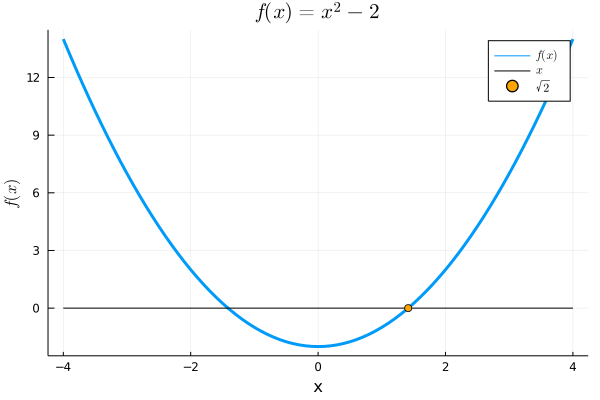

In [51]:
#collapse
using Plots
using LaTeXStrings

function f(x)
    return x^2 - 2
end

x = collect(-4:0.1:4)
xaxis = [0 for i in -4:0.1:4]
fx = map(f, x)
plot(x, fx, title=L"f(x)=x^2-2", lw=3, xlabel="x", ylabel=L"f(x)", label=L"f(x)")
plot!(x, xaxis, color="black", label=L"x")
scatter!([sqrt(2)], [0], label=L"\sqrt{2}", color="orange")

## Newton's method the easy way: Autodiff

 Newton's method essentially follows the algorithm outlined below:
- Set $x_{0} = g$ where g is some initial guess
- Set $x_{n} = x_{n-1} - \frac{f(x_{n-1})}{f'(x_{n-1})}$
- Continue until $f(x_{n}) < \epsilon$, where $\epsilon$ is the desired tolerance level (note this convergence criteria may not be sufficient for arbitrary functions, but suffices for this example)

The $f'$ portion of the algorithm presents an interesting challenge when implementing this in a language like python where most objects are not differentiable. In Julia, however, most objects _are differentiable_, so you get a trivial implementation using the `ForwardDiff` package. Also note in the implementation below- we are using arbitrary unicode characters! This definitely makes it feel like you are coding in math.

In [64]:
using ForwardDiff
using DataFrames


function newton_roots(k, ϵ)
    function f(x)
        return x^2 - k
    end
    
    x₀ = k
    xₙ = x₀
    # Sufficient convergence criteria
    while f(xₙ) > ϵ
        # Update step
        xₙ = xₙ - (f(xₙ) / ForwardDiff.derivative(f, xₙ))
    end
    return xₙ
end

result = DataFrame(
    x = [k for k in 1:10],
    sqrt_approx = [newton_roots(k, 0.001) for k in 1:10],
    sqrt_true = [sqrt(k) for k in 1:10])
result[!, "error"] = result.sqrt_true - result.sqrt_approx
result

,x,sqrt_approx,sqrt_true,error
,Int64,Real,Float64,Float64
1,1,1,1.0,0.0
2,2,1.41422,1.41421,-2.1239e-6
3,3,1.73214,1.73205,-9.20496e-5
4,4,2.0,2.0,-9.29223e-8
5,5,2.23607,2.23607,-9.18144e-7
6,6,2.44949,2.44949,-4.62882e-6
7,7,2.64577,2.64575,-1.57331e-5
8,8,2.82847,2.82843,-4.14471e-5
9,9,3.00009,3.0,-9.15541e-5


Not bad! You can see our approximation quickly converged to a reasonably accurate estimate of the standard implementation of `sqrt` function within Julia. If we need a lower error we can simply lower the tolerance threshold. Let's move on to another interesting example- Sierpinski Triangles!

## Computing the area of Sierpinski Triangles recursively in Julia

Rather than explaining what a Sierpinksi triangle is, it's easier to simply _show_ it below. Note the code is directly borrowed from the excellent [Introduction to Computation Thinking (MIT) course](https://computationalthinking.mit.edu/Spring21/).

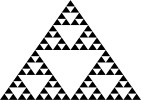

In [77]:
#collapse
using Compose


triangle() = compose(context(), polygon([(1, 1), (0, 1), (1 / 2, 0)]))

function place_in_3_corners(t)
    # Uses the Compose library to place 3 copies of t
    # in the 3 corners of a triangle.
    # treat this function as a black box,
    # or learn how it works from the Compose documentation here https://giovineitalia.github.io/Compose.jl/latest/tutorial/#Compose-is-declarative-1
    compose(context(),
        (context(1 / 4,   0, 1 / 2, 1 / 2), t),
        (context(0, 1 / 2, 1 / 2, 1 / 2), t),
        (context(1 / 2, 1 / 2, 1 / 2, 1 / 2), t))
end

function sierpinski(n)
    if n == 0
        triangle()
    else
        t = sierpinski(n - 1) # recursively construct a smaller sierpinski's triangle
        place_in_3_corners(t) # place it in the 3 corners of a triangle
    end
end

sierpinski(4)

Now suppose we wanted to compute the area of a Sierpinski triangle of order $n$ assuming that the area of $Sierpinski(0)$ is 1. It turns out this lends itself nicely to a _recursive_ solution.

In [82]:
function area_sierpinski(n)
    area = 1.0
    if n == 0
        return 1.0 * area
    else
        area = 0.75 * area_sierpinski(n-1)
    end
end

[area_sierpinski(i) for i in 0:10]

11-element Array{Float64,1}:
 1.0
 0.75
 0.5625
 0.421875
 0.31640625
 0.2373046875
 0.177978515625
 0.13348388671875
 0.1001129150390625
 0.07508468627929688
 0.056313514709472656

You can see that the recursive solution is very succinct, even elegant. While this could have been implemented just as easily in python, this was a fun reason to give Julia a test drive.